# Markov Chain Monte Carlo or How I Learned to Stop Worrying and Love the Sampler

## Road Map

### Why do I care?

### Overview of Metropolis-Hastings Algorithm
* Earliest and simplest sampling algorithm 

### What is likelihood?
* Step rejection or acceptance

### MH Algorithm in Action: Can we recover parameters of an unkown distribution?
* Create Fake Data
* Sample Using MH
* Did we find a good estimate of our parameters from our data?

### Pathological Sampling: What can go wrong?
* Convergence
* Burn in time
* Step size

### Futher Reading

## Why Sample?
* MCMC is used to solve high dimensional optimisation and integration problems
* In bayesian statistics it is more often the case that the integration problems are not analytically tractable
* Full distribution for parameters rather than just point estimates
* Compatibility intervals

### Sampling allows us to find the parameters which are most likely to have produced our data
Wait, how is this different than something like gradient descent, we can get get parameter estimates from that process too?

Gradient descent gives point estimates of our parameters while sampling gives us a distribution of possible values of our parameters. 

Sampling helps us answer the additional question of how certain we are about our parameter estimates.

## Animated Example of M-H Random Walk

https://chi-feng.github.io/mcmc-demo/app.html#RandomWalkMH,banana

## Metropolis-Hastings Algorithm

1. Have data (D) and parameters ($\theta$) we want to estimate (In our example the parameters would be $\mu$ and $\sigma$)
2. Sample around the parameter space using a markov chain
  * Initialize the parameters 
  * Choose another set of random parameters in the same area
  * Calculate the likelihood of that data coming from those parameters
  * If the new set of parameters has a higher likelihood always take that step and append that value to the chain.
  * If the new parameters have a lower likelihood do a coin flip to see if you take the step or not. The probability of making the step depends of the ratio of likelihood, ie if the new step is comparitively much less likely then it will also be less likely to take the step
    
3. Repeat

After a burn in period where the markov chain starts in an area of low likelihood, the chain will sample from areas with high likelihood proportionally more than lower likelihood areas. So, we can take all the accepted samples and plot them on a histogram and see which values have been sampled the most. This gives us the values of our distribution in question.

The useful property of these kinds of algorithms is that the time spent at each point in parameter space is propotional to the likelihood of those parameters given the data

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

## To Step or Not to Step, That is the Question: Likelihood

The likelihood of a set of parameter values, 𝜃, given observations 𝑥, is equal to the probability of seeing those observations given those parameter values.

$\hspace{70mm} L(\theta | x) = p(x |\theta)$

SIDENOTE: The definition of likelihood is slightly different if the distribution is continuous rather than discrete

Lets look at how we would calculate and compare the likelihood of two models given a few points of data.

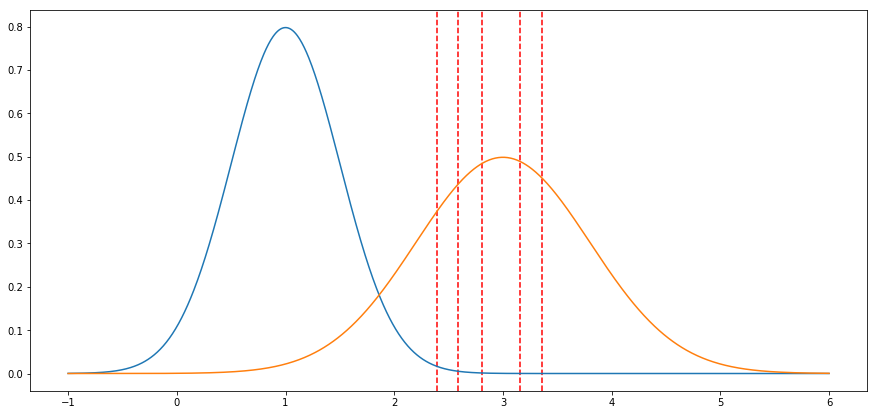

In [2]:
x = np.linspace(-1, 6, num=1000)

dist_1 = stats.norm(loc=1, scale=.5)
y_1 = dist_1.pdf(x)

dist_2 = stats.norm(loc=3, scale=.8)
y_2 = dist_2.pdf(x)

#Randomly choose which distribution to sample the data from
if np.random.rand() < .5:
    dist = dist_1
else:
    dist = dist_2
    
data = dist.rvs(5) #lets pick 5 random points
fig, ax = plt.subplots(figsize=(15, 7))

#Plot all points of data as vertical lines
for datum in data:
    ax.axvline(datum, linestyle='--', color='r')

#Plot each distribution
ax.plot(x, y_1)
ax.plot(x, y_2);

### Which distribution do you think is more likely to have generated the given data points, Orange or Blue?

### How can we give a numerical account of which is more likely?
Using each distributions probability density function we can calculate the value of the pdf at each of the data points being picked. We can then multiply each of the values together for each distribution to calculate the likelihood that all of the data was generated from each distribution.

### Comparing pdf values

In [3]:
for vals in zip(data, dist_1.pdf(data), dist_2.pdf(data)):
    print(f'datapoint: {vals[0]:.2}')
    print(f'dist_1 pdf value: {vals[1]:.2}')
    print(f'dist_2 pdf value: {vals[2]:.2}')
    print()
    
print('TOTAL')
print(f'dist_1 Likelihood: {np.prod(dist_1.pdf(data)):.2}')
print(f'dist_1 params --> mu: {dist_1.mean()} sigma: {dist_1.std()}')
print()
print(f'dist_2 Likelihood: {np.prod(dist_2.pdf(data)):.2}')
print(f'dist_1 params --> mu: {dist_2.mean()} sigma: {dist_2.std()}')

datapoint: 4.2
dist_1 pdf value: 8.2e-10
dist_2 pdf value: 0.16

datapoint: 3.2
dist_1 pdf value: 6.6e-05
dist_2 pdf value: 0.49

datapoint: 3.8
dist_1 pdf value: 9.8e-08
dist_2 pdf value: 0.29

datapoint: 3.9
dist_1 pdf value: 2.4e-08
dist_2 pdf value: 0.25

datapoint: 3.1
dist_1 pdf value: 0.00012
dist_2 pdf value: 0.5

TOTAL
dist_1 Likelihood: 1.5e-32
dist_1 params --> mu: 1.0 sigma: 0.5

dist_2 Likelihood: 0.0028
dist_1 params --> mu: 3.0 sigma: 0.8


## Accept or Reject

The accept or rejection criteria are as follows:
- If newLikelihood >= currentLikelihood always accept
- Otherwise do a weighted coin flip proportional to $\frac{newLikelihood}{currentLikelihood}$ to determine if the step is taken

Would we accept or reject a step starting from the parameter space of distribution 1 and going to distribution 2?

What if we started at the parameter space of distribution 2?

In [4]:
#helper function to calculate the likelihood that the data came from the distribution
def calculate_likelihood(data, mu, sigma):
    #Take in the mean and standard deviation values then calculate for each data point in data
    #the relative pobability of that point being drawn from this distribution
    pdf_values = stats.norm.pdf(data, loc=mu, scale=sigma)
    
    return np.prod(pdf_values) #take the product of all values

# Lets code up an example of finding parameters using sampling!

Challenge: Can we recover the parameters of the distribution we generated our fake data with?

## Create Ground Truth Distribution

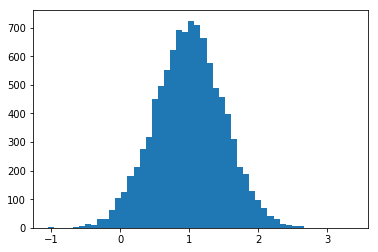

In [5]:
#scale = standard deviation (sigma) and loc = mean (mu)
distribution_shape = np.random.normal(loc=1, scale=0.5, size=10000)

fig, ax = plt.subplots()

ax.hist(distribution_shape, bins=50);

## Draw samples from Ground Truth Distribution

In [6]:
#Draw 100 samples from a normal distribution with a mean of 1 and standard deviation of 0.5 
#These data points will function as our observations that we will try to recover the parameters for. 

nums = np.random.normal(loc=1, scale=0.5, size=100)

## Initialize Parameters Mu (mean) and sigma (standard deviation)

In [7]:
#All of our mus(mean) will be appended to this list
mu = [1]

#Same but for our sigma(standard deviation) values
sigma = [3]

#stepsize controls how big of a step the chain will take to a new sample
stepsize= 0.1

## Lets Run the Algorithm!

In [11]:
steps = 100000

for i in range(steps):
    #Pick new mu and sigma values by picking a random value a stepsize away from the previous value
    new_mu = mu[-1] + np.random.normal(0, stepsize)
    new_sigma = sigma[-1] + np.random.normal(0, stepsize)
    
    #Calculate the likelihood that our data was generated by the current parameters and new parameters
    current_likelihood = calculate_likelihood(nums, mu[-1], sigma[-1])
    new_likelihood = calculate_likelihood(nums, new_mu, new_sigma)
    
    #Pick a random decimal from 0 to 1 and if it is less than the ratio of the new/current likelihood take the
    #step and append the new mu and sigma values, otherwise append the current mu and sigma again
    if np.random.random() < (new_likelihood / current_likelihood):
        mu.append(new_mu)
        sigma.append(new_sigma)
    else:
        mu.append(mu[-1])
        sigma.append(sigma[-1])
        

## Plot Traces of $\mu$ and $\sigma$ and Histograms of Values

You can see the first part of the trace looks very different from the rest. This is becasue when we randomly selected the initial parameters its usually the case that it starts in a low likelihood area. Then once the markov chain finds areas of high likelihood it will provide an unbiased sampling of the distribution.

Generally, this part of the trace is not used as it is not an accurate representation of the distribution. To overcome this problem you can specify a burn in time which indicates how many steps you will throw out before you will get unbiased samples from the distribution (This is generally around half of the steps). 

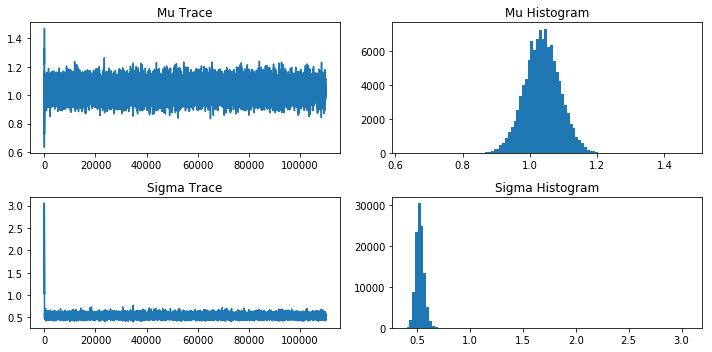

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

axes[0][0].plot(mu)
axes[0][0].set_title('Mu Trace')
axes[0][1].hist(mu, bins=100)
axes[0][1].set_title('Mu Histogram')

axes[1][0].plot(sigma)
axes[1][0].set_title('Sigma Trace')
axes[1][1].hist(sigma, bins=100)
axes[1][1].set_title('Sigma Histogram')
plt.tight_layout();

## Feel the Burn

Here we add in the burn in time which throws out the first part of the trace before it reaches convergence

As you can see the histograms are much clearer about the proper distributions

You can adjust the burn in time to include more samples depending on how long it takes to converge

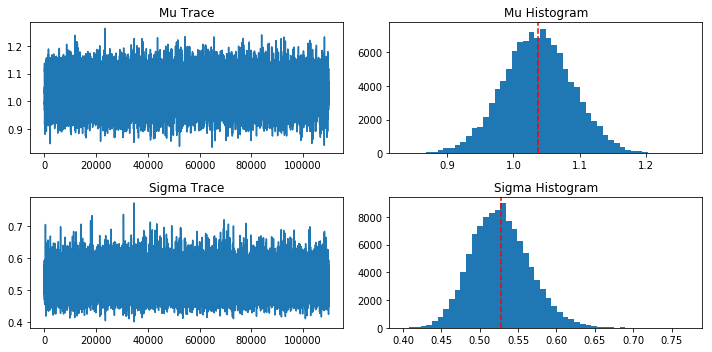

In [13]:
burn = 1000

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

axes[0][0].plot(mu[burn:])
axes[0][0].set_title('Mu Trace')
axes[0][1].hist(mu[burn:], bins=50)
axes[0][1].axvline(np.mean(mu[burn:]), linestyle='--', color='r')
axes[0][1].set_title('Mu Histogram')

axes[1][0].plot(sigma[burn:])
axes[1][0].set_title('Sigma Trace')
axes[1][1].hist(sigma[burn:], bins=50)
axes[1][1].axvline(np.mean(sigma[burn:]), linestyle='--', color='r')
axes[1][1].set_title('Sigma Histogram')
plt.tight_layout();

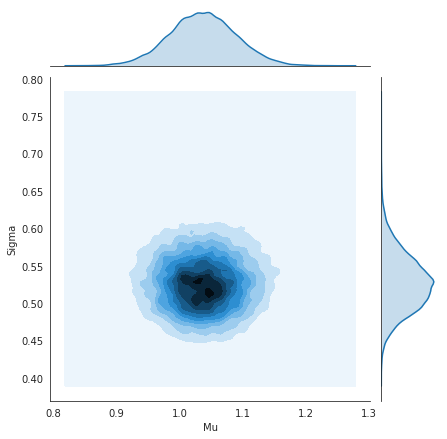

In [14]:
with sns.axes_style('white'):
     p = sns.jointplot(mu[burn:], sigma[burn:], kind='kde')
p.set_axis_labels('Mu', 'Sigma');

## Fun with StepSize: Giant Steps

How does step size effect our sampling?

Lets turn our for loop into a function so we can easily change the stepsize

In [15]:
def sample(nums, mu, sigma, stepsize, samples):
    mu = [mu]
    sigma = [sigma]
    while len(mu) < samples:
        new_mu = mu[-1] + np.random.normal(0, stepsize)
        new_sigma = sigma[-1] + np.random.normal(0, stepsize)

        current_likelihood = calculate_likelihood(nums, mu[-1], sigma[-1])
        new_likelihood = calculate_likelihood(nums, new_mu, new_sigma)

        if np.random.random() < (new_likelihood / current_likelihood):
            mu.append(new_mu)
            sigma.append(new_sigma)
        else:
            mu.append(mu[-1])
            sigma.append(sigma[-1])
    return mu, sigma

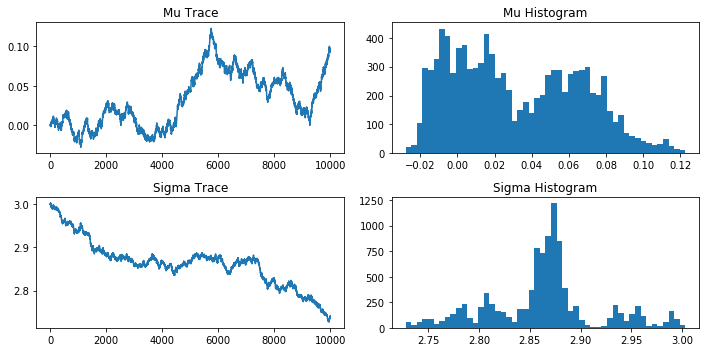

In [16]:
#Lets use a smaller step size of .001
mu_small_step, sigma_small_step = sample(nums, 0, 3, .001, 10000)

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

axes[0][0].plot(mu_small_step)
axes[0][0].set_title('Mu Trace')
axes[0][1].hist(mu_small_step, bins=50)
axes[0][1].set_title('Mu Histogram')

axes[1][0].plot(sigma_small_step)
axes[1][0].set_title('Sigma Trace')
axes[1][1].hist(sigma_small_step, bins=50)
axes[1][1].set_title('Sigma Histogram')
plt.tight_layout();

What happened here?

This doesn't look right at all. No more fat fuzzy worms!?! The traces haven't converged at all and the histograms are all over the place.

When we choose a very small step size the chain doesn't have enough time to step all the way over to the areas of high likelihood. Since we initiated our values for Mu at 0 we remain around the 0 because with each step we can't go very far. This means that the true value of 0.5 is not even considered. The same story for sigma. We initiated our value at 3 and it can't leave this area because our step size is so small. It never reaches the area of high likelihood around 1 and remains unconveraged.

It is possible that with enough steps we will eventually reach the areas of high likelihood but it could take a very very long time.

Lets try a much bigger step size and see what happens

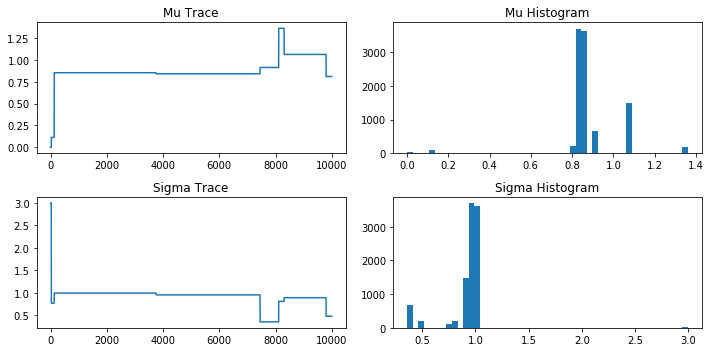

In [17]:
#Lets use a big step size of 10
mu_big_step, sigma_big_step = sample(nums, 0, 3, 10, 10000)

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

axes[0][0].plot(mu_big_step)
axes[0][0].set_title('Mu Trace')
axes[0][1].hist(mu_big_step, bins=50)
axes[0][1].set_title('Mu Histogram')

axes[1][0].plot(sigma_big_step)
axes[1][0].set_title('Sigma Trace')
axes[1][1].hist(sigma_big_step, bins=50)
axes[1][1].set_title('Sigma Histogram')
plt.tight_layout();

As we can see here there are much fewer new samples accepted. With a large step size we quickly move from the initialized values to the area of high likelihood but once there we are simply stuck rejecting almost every step because we can propose such a wide range of values and most every other step will be worse compared with the area of high likelihood. 

We get a quick approximation of the maximum value but when we look at the histogram we get very little information about the surrounding likelihood density.

Smaller steps would give us the fine grain detail we are after

## Other Sampling Algorithms 

* Gibbs Sampling
* Hamiltonian Monte Carlo
* NUTS

## Packages that Will do all the Sampling for you
* PyMC3
* Pyro
* Stan
* BUGS

# Sources

This notebook borrows heavily from parts of this video from PyData London 2017: 
[SaaaS - Sampling as an Algorithm Service, given by Vincent D. Warmerdam](https://www.youtube.com/watch?v=8g6oF8vUqTU)

[An Introduction to MCMC for Machine Learning](http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf)

If you are interested in the difference between likelihood and probability: [Statquest-Likelihood vs Probability](https://www.youtube.com/watch?v=pYxNSUDSFH4)
